In [ ]:
%matplotlib inline

In [1]:
import os
import copy
import time
from os.path import expanduser

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [2]:
plt.ion()

In [3]:
pipeline = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ])
}

In [4]:
data_dir = expanduser('~/data/hymenoptera_data')

In [5]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), pipeline[x])
    for x in ('train', 'val')
}

In [6]:
data_loaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=4,
        shuffle=True,
        num_workers=4)
    for x in ('train', 'val')}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ('train', 'val')}

In [8]:
class_names = image_datasets['train'].classes

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

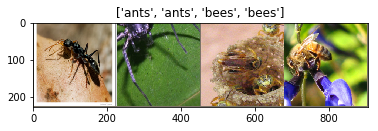

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ('train', 'val'):
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val acc: {best_acc:4f}')
    
    model.load_state_dict(best_weights)
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------
train loss: 0.5418 - acc: 0.7213
val loss: 0.2236 - acc: 0.9281

Epoch 1/24
----------
train loss: 0.4079 - acc: 0.8115
val loss: 0.2374 - acc: 0.8889

Epoch 2/24
----------
train loss: 0.3810 - acc: 0.8238
val loss: 0.2875 - acc: 0.9020

Epoch 3/24
----------
train loss: 0.4351 - acc: 0.7910
val loss: 0.3124 - acc: 0.8758

Epoch 4/24
----------
train loss: 0.4464 - acc: 0.8033
val loss: 0.3113 - acc: 0.8758

Epoch 5/24
----------
train loss: 0.4431 - acc: 0.8156
val loss: 0.3261 - acc: 0.8824

Epoch 6/24
----------
train loss: 0.4553 - acc: 0.8238
val loss: 0.3567 - acc: 0.8301

Epoch 7/24
----------
train loss: 0.3621 - acc: 0.8361
val loss: 0.1526 - acc: 0.9542

Epoch 8/24
----------
train loss: 0.3185 - acc: 0.8648
val loss: 0.1708 - acc: 0.9281

Epoch 9/24
----------
train loss: 0.2716 - acc: 0.8770
val loss: 0.1804 - acc: 0.9281

Epoch 10/24
----------
train loss: 0.2596 - acc: 0.8975
val loss: 0.1708 - acc: 0.9477

Epoch 11/24
----------
train loss: 0.3724 

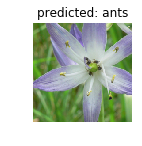

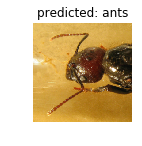

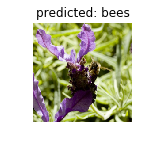

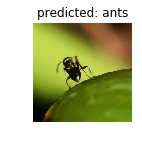

In [15]:
visualize_model(model, num_images=4)